In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchinfo import summary
from tqdm import tqdm
from nn_zoo.datamodules import MNISTDataModule
from nn_zoo.models.components import DepthwiseSeparableConv2d
import matplotlib.pyplot as plt

/Users/karan/projects/playground/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dm = MNISTDataModule(
        data_dir="../../data",
        dataset_params={
            "download": True,
            "transform": torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize((32, 32)),
                    torchvision.transforms.ToTensor(),
                ]
            ),
        },
        loader_params={
            "batch_size": 64
        },
    )

dm.setup()

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = DepthwiseSeparableConv2d(1, 32, 5, padding=0)
        self.conv2 = DepthwiseSeparableConv2d(32, 64, 5, padding=0)
        self.conv3 = DepthwiseSeparableConv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 2 * 2, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [106]:
class SGD(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, momentum=0):
        defaults = dict(lr=lr, momentum=momentum)
        super(SGD, self).__init__(params, defaults)
    
    def zero_grad(self, set_to_none: bool = True) -> None:
        return super().zero_grad(set_to_none)    
    
    def step(self, closure=None, plot=False):
        if plot:
            plt.figure(figsize=(20, 5))
        # update weights with momentum
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad_data = p.grad.data
                param_state = self.state[p]
                
                # Initialize momentum buffer if it doesn't exist
                if 'momentum_buffer' not in param_state:
                    buf = param_state['momentum_buffer'] = torch.clone(grad_data).detach()
                else:
                    buf = param_state['momentum_buffer'] * (group['momentum']) + grad_data * (1 - group['momentum'])


                if plot:
                    # print gradient statistics
                    print(f"min: {grad_data.min().item():2>.4f}, max: {grad_data.max().item():2>.4f}, mean: {grad_data.mean().item():2>.4f}, std: {grad_data.std().item():2>.4f}")


                    plt.subplot(1, 2, 1)
                    plt.hist(buf.flatten().detach().cpu().numpy(), bins=500, range=(-0.1, 0.1), log=True, alpha=0.5, label="momentum")

                    plt.subplot(1, 2, 2)
                    plt.hist(grad_data.flatten().detach().cpu().numpy(), bins=500, range=(-0.1, 0.1), log=True, alpha=0.5, label="gradient")

                p.data -= group['lr'] * buf

        if plot:
            plt.legend()
            plt.show()


In [107]:
# seed cpu and mps
torch.manual_seed(0)
torch.mps.manual_seed(0)

model = Model()
model = model.to("mps")
print(summary(model, input_size=(1, 1, 32, 32), device="mps", depth=1))

optimizer = SGD(model.parameters(), lr=0.1, momentum=0.5)
loss_fn = F.cross_entropy
# %timeit optimizer.step()

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─DepthwiseSeparableConv2d: 1-1          [1, 32, 28, 28]           90
├─DepthwiseSeparableConv2d: 1-2          [1, 64, 10, 10]           2,944
├─DepthwiseSeparableConv2d: 1-3          [1, 128, 5, 5]            8,960
├─Linear: 1-4                            [1, 10]                   5,130
Total params: 17,124
Trainable params: 17,124
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.59
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.07
Estimated Total Size (MB): 0.39


In [110]:
@torch.no_grad()
def eval(model, loader):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    for x, y in loader:
        x, y = x.to("mps"), y.to("mps")
        y_hat = model(x)
        pred = y_hat.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()
        total += len(x)
        loss += loss_fn(y_hat, y).item()
    return correct / total, loss / len(loader)

# seed cpu and mps
torch.manual_seed(0)
torch.mps.manual_seed(0)

for epoch in range(10):
    model.train()
    val_acc, val_loss = eval(model, val_loader)

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}", ncols=150)
    for x, y in pbar:
        x, y = x.to("mps"), y.to("mps")
        optimizer.zero_grad()
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()

        pbar.set_postfix_str(f"loss: {loss.item():.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")
        
        break
    break


val_acc, val_loss = eval(model, val_loader)
print(f"val_acc: {val_acc:.4f}, val_loss: {val_loss:.4f}")

Epoch 0:   0%|                                                               | 0/938 [00:00<?, ?it/s, loss: 0.4321, val_loss: 0.4100, val_acc: 0.8644]


val_acc: 0.9065, val_loss: 0.3045


In [111]:
val_acc, val_loss = eval(model, val_loader)
print(f"val_acc: {val_acc:.4f}, val_loss: {val_loss:.4f}")

val_acc: 0.9065, val_loss: 0.3045


min: -0.1208, max: 0.0214, mean: -0.0573, std: 0.0450
min: -0.1970, max: -0.1970, mean: -0.1970, std: nan
min: -0.1126, max: 0.1100, mean: 0.0013, std: 0.0305
min: -0.0341, max: 0.0832, mean: 0.0035, std: 0.0178
min: -0.0580, max: 0.3705, mean: 0.0049, std: 0.0421
min: -0.0302, max: 0.0664, mean: 0.0011, std: 0.0209
min: -0.1844, max: 0.2163, mean: -0.0002, std: 0.0187
min: -0.0249, max: 0.0575, mean: 0.0046, std: 0.0142
min: -0.4248, max: 0.1674, mean: -0.0075, std: 0.0435
min: -0.0600, max: 0.0421, mean: -0.0033, std: 0.0220
min: -0.1624, max: 0.2670, mean: 0.0003, std: 0.0202
min: -0.0586, max: 0.0517, mean: -0.0022, std: 0.0179
min: -0.2806, max: 0.6336, mean: -0.0000, std: 0.0533
min: -0.0375, max: 0.1116, mean: -0.0000, std: 0.0428


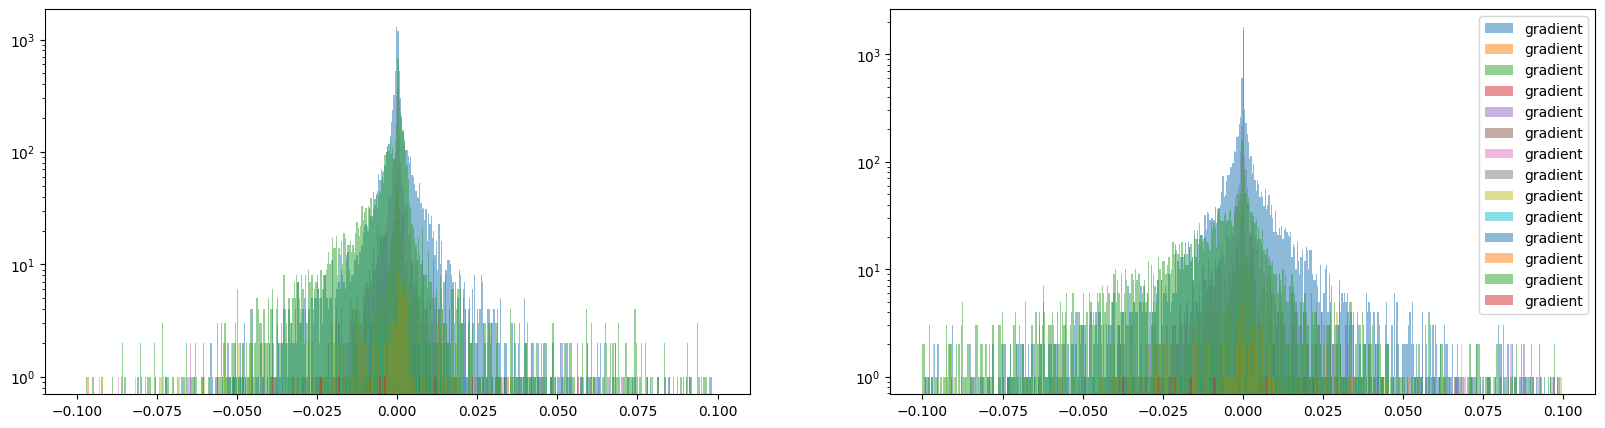

In [112]:
optimizer.step(plot=True)

min: -0.0412, max: 0.0232, mean: -0.0103, std: 0.0162
min: 0.0222, max: 0.0222, mean: 0.0222, std: nan
min: -0.0580, max: 0.0225, mean: -0.0042, std: 0.0134
min: -0.0185, max: 0.0221, mean: -0.0008, std: 0.0065
min: -0.0955, max: 0.0163, mean: -0.0020, std: 0.0108
min: -0.0230, max: 0.0154, mean: -0.0006, std: 0.0074
min: -0.0886, max: 0.0703, mean: 0.0000, std: 0.0074
min: -0.0180, max: 0.0136, mean: -0.0018, std: 0.0049
min: -0.1578, max: 0.1967, mean: 0.0006, std: 0.0222
min: -0.0256, max: 0.0319, mean: 0.0003, std: 0.0087
min: -0.0810, max: 0.0783, mean: -0.0001, std: 0.0074
min: -0.0199, max: 0.0248, mean: 0.0011, std: 0.0068
min: -0.2279, max: 0.0967, mean: -0.0000, std: 0.0187
min: -0.0471, max: 0.0165, mean: -0.0000, std: 0.0179


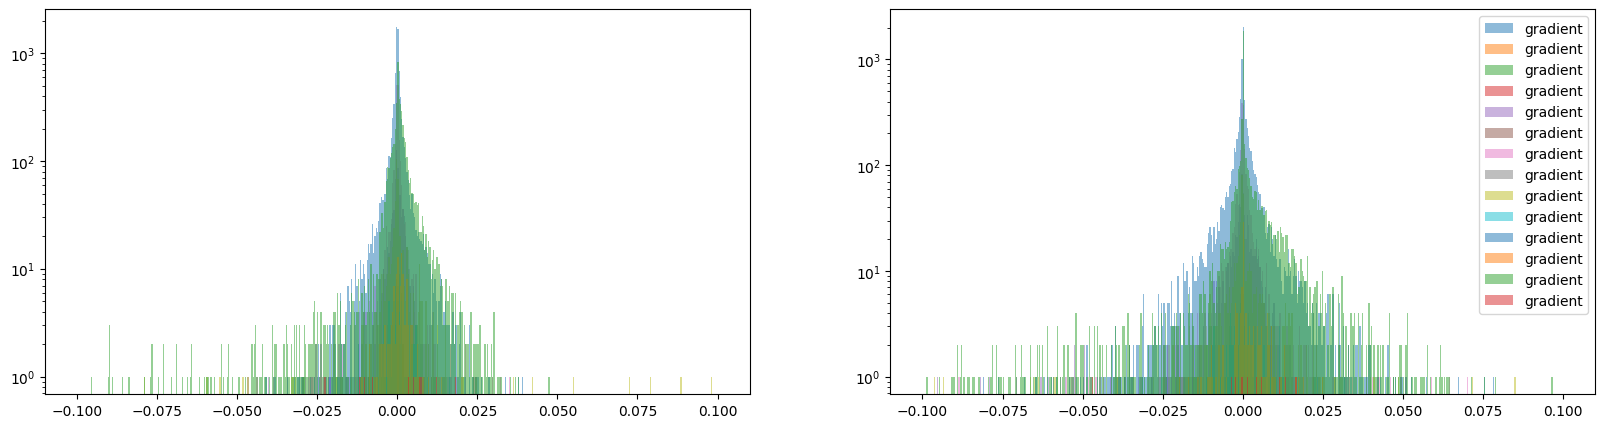

In [109]:
optimizer.step(plot=True)